In [13]:
import h5py
import numpy as np
import numpy.lib.recfunctions as rfn
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import yaml
from scipy.interpolate import CubicSpline

In [9]:
import pandas as pd
df = pd.read_csv('NIST_proton_read.txt', header=None, sep=' ')

In [10]:
rho=1.38
dEdx_NIST = df[1][1:].to_numpy(dtype=float) * rho
Range_NIST = df[2][1:].to_numpy(dtype=float) / rho

In [11]:
def alpha(dEdx, Ab=0.8, kb=0.0486, E=0.5, rho=1.38):
    alpha = Ab / (1 + kb/(E*rho)*dEdx)
    return alpha

In [4]:
Ab_true = 0.8
kb_true = 0.0486
E=0.5
rho=1.38
def Ab(kb, dEdx, E=0.5, rho=1.38):
    alpha = Ab_true / (1 + kb_true/(E*rho)*dEdx)
    Ab = alpha * (1+kb/(E*rho)*dEdx)
    return Ab

In [78]:
f=h5py.File("edepsim_p_5000.h5")
# f=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_5000.h5")
segs = f['segments']
traj = f['trajectories']
vtx = f['vertices']

## Raw

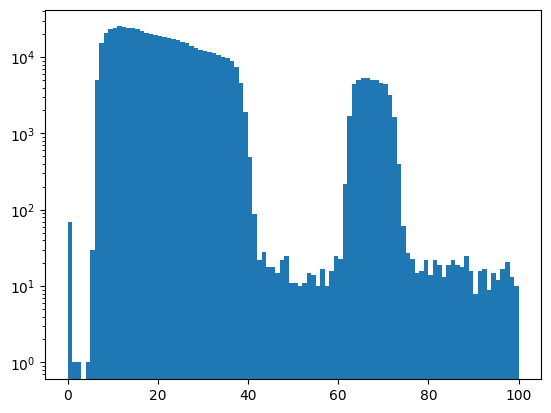

In [3]:
plt.hist(segs[segs['pdgId']==2212]['dEdx'],range=[0,100],bins=100)
plt.yscale("log")
plt.show()

In [4]:
np.unique(segs[segs['dEdx']<5]['pdgId'],return_counts=True)

(array([       -11,         11,         22,       2112,       2212,
        1000020040, 1000150330, 1000160320, 1000160330, 1000160340,
        1000160350, 1000160360, 1000170350, 1000170360, 1000170370,
        1000170380, 1000170390, 1000180360, 1000180370, 1000180380,
        1000180390, 1000180400, 1000180410, 1000190380, 1000190390,
        1000190400], dtype=int32),
 array([  593,  8059,  8071, 17109,    73,    31,     2,     1,     1,
            4,     4,     6,     2,     2,    11,     5,     1,     7,
           19,    67,    32,    50,     4,     1,    29,    10]))

## Segments in contained proton trajectories

In [5]:
# active volume (doesn't need to be accurate here)
active_range = [[-30,30],[-80,40],[-30,30]]

def x_in_range(x_list):
    x_mask = x_list > active_range[0][0]
    x_mask = x_mask & (x_list < active_range[0][1])
    return x_mask

def y_in_range(y_list):
    y_mask = y_list > active_range[1][0]
    y_mask = y_mask & (y_list < active_range[1][1])
    return y_mask

def z_in_range(z_list):
    z_mask = z_list > active_range[2][0]
    z_mask = z_mask & (z_list < active_range[2][1])
    return z_mask

def points_in_active(p):
    x_mask = x_in_range(p[:,0])
    y_mask = y_in_range(p[:,1])
    z_mask = z_in_range(p[:,2])
    return x_mask & y_mask & z_mask
    
def traj_in_active(traj):
    start_mask = points_in_active(traj['xyz_start'])
    end_mask = points_in_active(traj['xyz_end'])
    return start_mask & end_mask

In [7]:
traj_active_mask = traj_in_active(traj)
active_vol_traj = traj[traj_active_mask]
active_vol_p = active_vol_traj[active_vol_traj['pdgId']==2212]

In [8]:
mask = np.in1d(segs['file_trackID'], active_vol_p['file_trackID'])
active_vol_segs = segs[mask]

In [9]:
with h5py.File("edepsim_p_only_active_vol_5000.h5", "w") as f_out:
    f_out.create_dataset('segments', data=active_vol_segs)
    f_out.create_dataset('trajectories', data=active_vol_p)
    f_out.create_dataset('vertices', data=vtx)

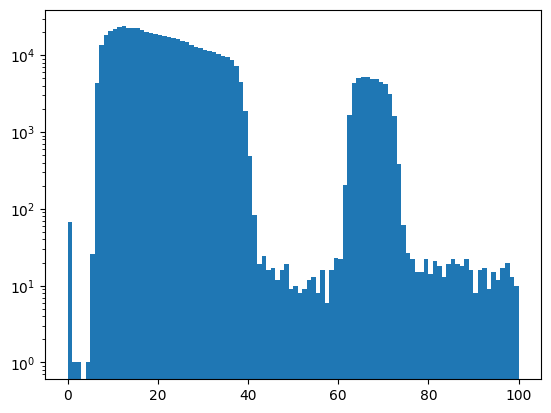

In [10]:
plt.hist(active_vol_segs['dEdx'],range=[0,100],bins=100)
plt.yscale("log")
plt.show()

find the range for each segment

In [ ]:
traj_end = active_vol_p[active_vol_p['trackID']==seg['trackID']]['xyz_end']

In [61]:
unique_file_traj_id = np.unique(active_vol_p['file_trackID'])

for i_traj, this_traj in enumerate(unique_file_traj_id):
    if i_traj%500 == 0:
        print("this_traj: ", this_traj)
    traj_mask = active_vol_segs['file_trackID'] == this_traj
    traj_end = active_vol_p[active_vol_p['file_trackID'] == this_traj]['xyz_end'][0]
    # print("-------------")
    # print("traj_end: ", traj_end)
    # the segments are already sorted by segment time
    traj_segs =  active_vol_segs[traj_mask]
    # print("traj_segs['t0']: ", traj_segs['t0'])
    
    idx = np.argsort(traj_segs['t0'])
    traj_segs = np.take_along_axis(traj_segs, idx, axis=0)
    # print("idx: ", idx)
    # print("traj_segs['t0']: ", traj_segs['t0'])
    if 'range' not in traj_segs.dtype.names:
        range = np.zeros(traj_segs.shape[0], dtype=[('range', 'f4')])
        traj_segs = rfn.merge_arrays((traj_segs, range), flatten=True)

    acc_len = 0
    for seg in reversed(traj_segs):
        seg['range'] = acc_len + seg['dx'] * 0.5
        acc_len += seg['dx']

    if i_traj == 0:
        active_vol_segs_w_range = traj_segs
    else:
        active_vol_segs_w_range = np.append(active_vol_segs_w_range, traj_segs)

    if i_traj % 500 == 0:
        with h5py.File("edepsim_p_only_active_vol_5000.h5", "w") as f_out:
            f_out.create_dataset('segments', data=active_vol_segs_w_range)
            f_out.create_dataset('trajectories', data=active_vol_p)
            f_out.create_dataset('vertices', data=vtx)
 

this_traj:  0
this_traj:  1143
this_traj:  2335
this_traj:  3734
this_traj:  4995
this_traj:  5964
this_traj:  7004
this_traj:  8226
this_traj:  9350
this_traj:  10528
this_traj:  11902
this_traj:  13282
this_traj:  14535
this_traj:  16004
this_traj:  17216
this_traj:  18436
this_traj:  19880
this_traj:  21290
this_traj:  22614
this_traj:  23982
this_traj:  25404
this_traj:  26859
this_traj:  28192
this_traj:  29553
this_traj:  31066
this_traj:  32280
this_traj:  33770
this_traj:  34668
this_traj:  36032
this_traj:  37310
this_traj:  38697
this_traj:  40395
this_traj:  41639
this_traj:  42935
this_traj:  44359
this_traj:  45393
this_traj:  46620
this_traj:  47790
this_traj:  49078
this_traj:  50463
this_traj:  51903
this_traj:  53338
this_traj:  54519
this_traj:  55934
this_traj:  57110
this_traj:  58330
this_traj:  59518
this_traj:  60638
this_traj:  61851
this_traj:  63323
this_traj:  65004
this_traj:  66229
this_traj:  67516
this_traj:  68807
this_traj:  70145
this_traj:  71726
this

In [ ]:
with h5py.File("edepsim_p_only_active_vol_5000.h5", "w") as f_out:
    f_out.create_dataset('segments', data=active_vol_segs_w_range)
    f_out.create_dataset('trajectories', data=active_vol_p)
    f_out.create_dataset('vertices', data=vtx)

## Fill the estimated dE/dx in "segments" dataset

#### dE/dx with NIST cubic interpolation

In [14]:
with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r") as f_in:
    with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx_cubic.h5", "w") as f_out:

        seg = f_in['segments']
        traj = f_in['trajectories']
        vtx = f_in['vertices']

        f_out.create_dataset('segments', data=seg)
        f_out.create_dataset('trajectories', data=traj)
        f_out.create_dataset('vertices', data=vtx)
        
        seg_new = f_out['segments']
        cs = CubicSpline(Range_NIST, dEdx_NIST)
        seg_new['dEdx'] = cs(seg_new['range'])
        seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']

        print("f_in['segments']['dEdx']: ", f_in['segments']['dEdx'])
        print("f_out['segments']['dEdx']: ", f_out['segments']['dEdx'])

f_in['segments']['dEdx']:  [  8.747436   9.206473  10.449196 ...  37.23355   64.82753  564.44147 ]
f_out['segments']['dEdx']:  [  8.680512   9.550185  10.527563 ...  34.78936   50.760994 363.99854 ]


#### dE/dx with NIST linear interpolation

In [18]:
with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r") as f_in:
    with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx.h5", "w") as f_out:

        seg = f_in['segments']
        traj = f_in['trajectories']
        vtx = f_in['vertices']

        f_out.create_dataset('segments', data=seg)
        f_out.create_dataset('trajectories', data=traj)
        f_out.create_dataset('vertices', data=vtx)
        
        seg_new = f_out['segments']
        seg_new['dEdx'] = np.interp(seg_new['range'], Range_NIST, dEdx_NIST)
        seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']

        print("f_in['segments']['dEdx']: ", f_in['segments']['dEdx'])
        print("f_out['segments']['dEdx']: ", f_out['segments']['dEdx'])

f_in['segments']['dEdx']:  [  8.747436   9.206473  10.449196 ...  37.23355   64.82753  564.44147 ]
f_out['segments']['dEdx']:  [  8.689144    9.56203    10.5285425 ...  34.93174    50.800705
 363.9659   ]


#### dE/dx with NIST linear interpolation and shift -1MeV/cm (negative?)

In [7]:
with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r") as f_in:
    with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx-1.h5", "w") as f_out:

        seg = f_in['segments']
        traj = f_in['trajectories']
        vtx = f_in['vertices']

        f_out.create_dataset('segments', data=seg)
        f_out.create_dataset('trajectories', data=traj)
        f_out.create_dataset('vertices', data=vtx)
        
        seg_new = f_out['segments']
        seg_new['dEdx'] = np.interp(seg_new['range'], Range_NIST, dEdx_NIST)-1
        seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']

        print("f_in['segments']['dEdx']: ", f_in['segments']['dEdx'])
        print("f_out['segments']['dEdx']: ", f_out['segments']['dEdx'])

f_in['segments']['dEdx']:  [  8.747436   9.206473  10.449196 ...  37.23355   64.82753  564.44147 ]
f_out['segments']['dEdx']:  [  7.689144    8.56203     9.5285425 ...  33.93174    49.800705
 362.9659   ]


#### dE/dx with NIST linear interpolation and shift +1MeV/cm

In [6]:
with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r") as f_in:
    with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx+1.h5", "w") as f_out:

        seg = f_in['segments']
        traj = f_in['trajectories']
        vtx = f_in['vertices']

        f_out.create_dataset('segments', data=seg)
        f_out.create_dataset('trajectories', data=traj)
        f_out.create_dataset('vertices', data=vtx)
        
        seg_new = f_out['segments']
        seg_new['dEdx'] = np.interp(seg_new['range'], Range_NIST, dEdx_NIST)+1
        seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']

        print("f_in['segments']['dEdx']: ", f_in['segments']['dEdx'])
        print("f_out['segments']['dEdx']: ", f_out['segments']['dEdx'])

f_in['segments']['dEdx']:  [  8.747436   9.206473  10.449196 ...  37.23355   64.82753  564.44147 ]
f_out['segments']['dEdx']:  [  9.689144   10.56203    11.5285425 ...  35.93174    51.800705
 364.9659   ]


#### dE/dx with ArgoNEUT PIDA modelling

In [6]:
PIDA_A=17
PIDA_b=-0.42
with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r") as f_in:
    with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_PIDA_dEdx.h5", "w") as f_out:

        seg = f_in['segments']
        traj = f_in['trajectories']
        vtx = f_in['vertices']

        f_out.create_dataset('segments', data=seg)
        f_out.create_dataset('trajectories', data=traj)
        f_out.create_dataset('vertices', data=vtx)
        
        seg_new = f_out['segments']
        seg_new['dEdx'] = PIDA_A*(seg_new['range']**PIDA_b)
        seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']

        print("f_in['segments']['dEdx']: ", f_in['segments']['dEdx'])
        print("f_out['segments']['dEdx']: ", f_out['segments']['dEdx'])

f_in['segments']['dEdx']:  [  8.747436   9.206473  10.449196 ...  37.23355   64.82753  564.44147 ]
f_out['segments']['dEdx']:  [   8.606147    9.458366   10.403481 ...   32.578403   46.72347
 1132.3861  ]


/lscratch/cyifan/tmp/ipykernel_1263388/362508394.py:15: RuntimeWarning: divide by zero encountered in power
  seg_new['dEdx'] = PIDA_A*(seg_new['range']**PIDA_b)
/lscratch/cyifan/tmp/ipykernel_1263388/362508394.py:16: RuntimeWarning: invalid value encountered in multiply
  seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']


## Break segments into pieces with dx = 0.1 cm

In [5]:
step = 0.1
with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r") as f_in:
    with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx_dx_0.1cm.h5", "w") as f_out:

        seg = f_in['segments']
        traj = f_in['trajectories']
        vtx = f_in['vertices']
        
        new_seg = []
        i_seg = 0
        for this_seg in seg:
            
            #remove edep-sim segments that are smaller than 0.1cm
            if this_seg['range'] < 0.1:
                continue
            
            n_seg = int(this_seg['dx'] // step + 1)
                        
            x_start = this_seg['x_start']
            y_start = this_seg['y_start']
            z_start = this_seg['z_start']
            
            norm_delta_x = (this_seg['x_end'] - this_seg['x_start']) / this_seg['dx']
            norm_delta_y = (this_seg['y_end'] - this_seg['y_start']) / this_seg['dx']
            norm_delta_z = (this_seg['z_end'] - this_seg['z_start']) / this_seg['dx']

            for i_subseg in range(n_seg):
                this_new_seg = this_seg.copy()
                this_new_seg['x_start'] = x_start
                this_new_seg['y_start'] = y_start
                this_new_seg['z_start'] = z_start
                
                if i_subseg != n_seg - 1:
                    
                    this_new_seg['x_end'] = x_start + norm_delta_x * step
                    this_new_seg['y_end'] = y_start + norm_delta_y * step
                    this_new_seg['z_end'] = z_start + norm_delta_z * step
                    
                    this_new_seg['dx'] = step
                    this_new_seg['dE'] = this_new_seg['dEdx'] * step
                else:
                    last_step = np.linalg.norm(np.array([this_seg['x_end']-x_start, this_seg['y_end']-y_start, this_seg['z_end']-z_start]))

                    this_new_seg['x_end'] = x_start + norm_delta_x * last_step
                    this_new_seg['y_end'] = y_start + norm_delta_y * last_step
                    this_new_seg['z_end'] = z_start + norm_delta_z * last_step
                    
                    this_new_seg['dx'] = last_step
                    this_new_seg['dE'] = this_new_seg['dEdx'] * last_step
                                       
                this_new_seg['x'] = (this_new_seg['x_start'] + this_new_seg['x_end']) * 0.5
                this_new_seg['y'] = (this_new_seg['y_start'] + this_new_seg['y_end']) * 0.5
                this_new_seg['z'] = (this_new_seg['z_start'] + this_new_seg['z_end']) * 0.5
                
                this_new_seg['segment_id'] = i_seg

                new_seg.append(this_new_seg)
                
                i_seg= i_seg+1
                
                x_start = this_new_seg['x_end']
                y_start = this_new_seg['y_end']
                z_start = this_new_seg['z_end']

        
        new_seg = np.array(new_seg)
           
        f_out.create_dataset('segments', data=new_seg)
        f_out.create_dataset('trajectories', data=traj)
        f_out.create_dataset('vertices', data=vtx)
        
        unique_file_traj_id = np.unique(traj['file_trackID'])
        n_total = len(np.unique(traj['file_trackID']))

        for i_traj, this_traj in enumerate(unique_file_traj_id):
            if i_traj%1000 == 0:
                print(f"progress: {i_traj} / {n_total}")
            traj_mask = new_seg['file_trackID'] == this_traj
            traj_end = traj[traj['file_trackID'] == this_traj]['xyz_end'][0]
            # print("-------------")
            # print("traj_end: ", traj_end)
            # the segments are already sorted by segment time
            traj_segs =  new_seg[traj_mask]
            # print("traj_segs['t0']: ", traj_segs['t0'])

            idx = np.argsort(traj_segs['t0'])
            traj_segs = np.take_along_axis(traj_segs, idx, axis=0)
            # print("idx: ", idx)
            # print("traj_segs['t0']: ", traj_segs['t0'])
            if 'range' not in traj_segs.dtype.names:
                range = np.zeros(traj_segs.shape[0], dtype=[('range', 'f4')])
                traj_segs = rfn.merge_arrays((traj_segs, range), flatten=True)

            acc_len = 0
            for seg in reversed(traj_segs):
                seg['range'] = acc_len + seg['dx'] * 0.5
                acc_len += seg['dx']
      
#             if i_traj == 0:
#                 active_vol_segs_w_range = traj_segs
#             else:
#                 active_vol_segs_w_range = np.append(active_vol_segs_w_range, traj_segs)
                
            if i_traj % 500 == 0:
                f_out['segments'][traj_mask] = traj_segs
        
        seg_new = f_out['segments']
        seg_new['dEdx'] = np.interp(seg_new['range'], Range_NIST, dEdx_NIST)
        seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']

        print("f_in['segments']['dEdx']: ", f_in['segments']['dEdx'])
        print("f_out['segments']['dEdx']: ", f_out['segments']['dEdx'])


progress: 0 / 50102
progress: 1000 / 50102
progress: 2000 / 50102
progress: 3000 / 50102
progress: 4000 / 50102
progress: 5000 / 50102
progress: 6000 / 50102
progress: 7000 / 50102
progress: 8000 / 50102
progress: 9000 / 50102
progress: 10000 / 50102
progress: 11000 / 50102
progress: 12000 / 50102
progress: 13000 / 50102
progress: 14000 / 50102
progress: 15000 / 50102
progress: 16000 / 50102
progress: 17000 / 50102
progress: 18000 / 50102
progress: 19000 / 50102
progress: 20000 / 50102
progress: 21000 / 50102
progress: 22000 / 50102
progress: 23000 / 50102
progress: 24000 / 50102
progress: 25000 / 50102
progress: 26000 / 50102
progress: 27000 / 50102
progress: 28000 / 50102
progress: 29000 / 50102
progress: 30000 / 50102
progress: 31000 / 50102
progress: 32000 / 50102
progress: 33000 / 50102
progress: 34000 / 50102
progress: 35000 / 50102
progress: 36000 / 50102
progress: 37000 / 50102
progress: 38000 / 50102
progress: 39000 / 50102
progress: 40000 / 50102
progress: 41000 / 50102
progr

In [5]:
step = 0.1
with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r") as f_in:
    with h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_dx_0.1cm.h5", "w") as f_out:

        seg = f_in['segments']
        traj = f_in['trajectories']
        vtx = f_in['vertices']
        
        new_seg = []
        i_seg = 0
        for this_seg in seg:
#             if i_seg>200:
#                 break
                
            #remove edep-sim segments that are smaller than 0.1cm
            if this_seg['range'] < 0.1:
                continue
            
            n_seg = int(this_seg['dx'] // step + 1)
                        
            x_start = this_seg['x_start']
            y_start = this_seg['y_start']
            z_start = this_seg['z_start']
            
            norm_delta_x = (this_seg['x_end'] - this_seg['x_start']) / this_seg['dx']
            norm_delta_y = (this_seg['y_end'] - this_seg['y_start']) / this_seg['dx']
            norm_delta_z = (this_seg['z_end'] - this_seg['z_start']) / this_seg['dx']

            for i_subseg in range(n_seg):
                this_new_seg = this_seg.copy()
                this_new_seg['x_start'] = x_start
                this_new_seg['y_start'] = y_start
                this_new_seg['z_start'] = z_start
                
                if i_subseg != n_seg - 1:
                    
                    this_new_seg['x_end'] = x_start + norm_delta_x * step
                    this_new_seg['y_end'] = y_start + norm_delta_y * step
                    this_new_seg['z_end'] = z_start + norm_delta_z * step
                    
                    this_new_seg['dx'] = step
                    this_new_seg['dE'] = this_new_seg['dEdx'] * step
                else:
                    last_step = np.linalg.norm(np.array([this_seg['x_end']-x_start, this_seg['y_end']-y_start, this_seg['z_end']-z_start]))

                    this_new_seg['x_end'] = x_start + norm_delta_x * last_step
                    this_new_seg['y_end'] = y_start + norm_delta_y * last_step
                    this_new_seg['z_end'] = z_start + norm_delta_z * last_step
                    
                    this_new_seg['dx'] = last_step
                    this_new_seg['dE'] = this_new_seg['dEdx'] * last_step
                                       
                this_new_seg['x'] = (this_new_seg['x_start'] + this_new_seg['x_end']) * 0.5
                this_new_seg['y'] = (this_new_seg['y_start'] + this_new_seg['y_end']) * 0.5
                this_new_seg['z'] = (this_new_seg['z_start'] + this_new_seg['z_end']) * 0.5
                
                this_new_seg['segment_id'] = i_seg

                new_seg.append(this_new_seg)
                
                i_seg= i_seg+1
                
                x_start = this_new_seg['x_end']
                y_start = this_new_seg['y_end']
                z_start = this_new_seg['z_end']

        
        new_seg = np.array(new_seg)
           
        f_out.create_dataset('segments', data=new_seg)
        f_out.create_dataset('trajectories', data=traj)
        f_out.create_dataset('vertices', data=vtx)
        
        unique_file_traj_id = np.unique(traj['file_trackID'])
        n_total = len(np.unique(traj['file_trackID']))

        for i_traj, this_traj in enumerate(unique_file_traj_id):
            if i_traj%1000 == 0:
                print(f"progress: {i_traj} / {n_total}")
            traj_mask = new_seg['file_trackID'] == this_traj
            traj_end = traj[traj['file_trackID'] == this_traj]['xyz_end'][0]
            # print("-------------")
            # print("traj_end: ", traj_end)
            # the segments are already sorted by segment time
            traj_segs =  new_seg[traj_mask]
            # print("traj_segs['t0']: ", traj_segs['t0'])

            idx = np.argsort(traj_segs['t0'])
            traj_segs = np.take_along_axis(traj_segs, idx, axis=0)
            # print("idx: ", idx)
            # print("traj_segs['t0']: ", traj_segs['t0'])
            if 'range' not in traj_segs.dtype.names:
                range = np.zeros(traj_segs.shape[0], dtype=[('range', 'f4')])
                traj_segs = rfn.merge_arrays((traj_segs, range), flatten=True)
                
#             print("traj_segs['range']: ", traj_segs['range'])
#             print("traj_segs['dx']: ", traj_segs['dx'])
#             print("traj_segs['dEdx']: ", traj_segs['dEdx'])
#             print("traj_segs['segment_id']: ", traj_segs['segment_id'])
            
            acc_len = 0
            for seg in reversed(traj_segs):
                seg['range'] = acc_len + seg['dx'] * 0.5
                acc_len += seg['dx']
            # print("traj_segs: ", traj_segs)
#             print("traj_segs['range']: ", traj_segs['range'])
      
#             if i_traj == 0:
#                 active_vol_segs_w_range = traj_segs
#             else:
#                 active_vol_segs_w_range = np.append(active_vol_segs_w_range, traj_segs)
                
            if i_traj % 500 == 0:
                f_out['segments'][traj_mask] = traj_segs
        
#         seg_new = f_out['segments']
#         seg_new['dEdx'] = np.interp(seg_new['range'], Range_NIST, dEdx_NIST)
#         seg_new['dE'] = seg_new['dEdx'] * seg_new['dx']

#         print("f_in['segments']['dEdx']: ", f_in['segments']['dEdx'])
#         print("f_out['segments']['dEdx']: ", f_out['segments']['dEdx'])


progress: 0 / 50102
progress: 1000 / 50102
progress: 2000 / 50102
progress: 3000 / 50102
progress: 4000 / 50102
progress: 5000 / 50102
progress: 6000 / 50102
progress: 7000 / 50102
progress: 8000 / 50102
progress: 9000 / 50102
progress: 10000 / 50102
progress: 11000 / 50102
progress: 12000 / 50102
progress: 13000 / 50102
progress: 14000 / 50102
progress: 15000 / 50102
progress: 16000 / 50102
progress: 17000 / 50102
progress: 18000 / 50102
progress: 19000 / 50102
progress: 20000 / 50102
progress: 21000 / 50102
progress: 22000 / 50102
progress: 23000 / 50102
progress: 24000 / 50102
progress: 25000 / 50102
progress: 26000 / 50102
progress: 27000 / 50102
progress: 28000 / 50102
progress: 29000 / 50102
progress: 30000 / 50102
progress: 31000 / 50102
progress: 32000 / 50102
progress: 33000 / 50102
progress: 34000 / 50102
progress: 35000 / 50102
progress: 36000 / 50102
progress: 37000 / 50102
progress: 38000 / 50102
progress: 39000 / 50102
progress: 40000 / 50102
progress: 41000 / 50102
progr

## Range and dE/dx

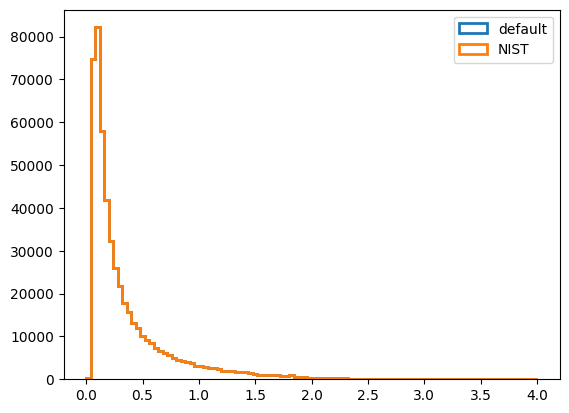

In [26]:
f1=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r")
f2=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx.h5", "r")

seg1=f1['segments']
seg2=f2['segments']

plt.hist(seg1[(seg1['range']>0.15)&(seg1['dx']>1E-2)]['dx'], range=[0,4], bins=100, histtype='step', linewidth=2, label = "default")
plt.hist(seg2[(seg2['range']>0.15)&(seg2['dx']>1E-2)]['dx'], range=[0,4], bins=100, histtype='step', linewidth=2, label = "NIST")

plt.legend()
plt.show()

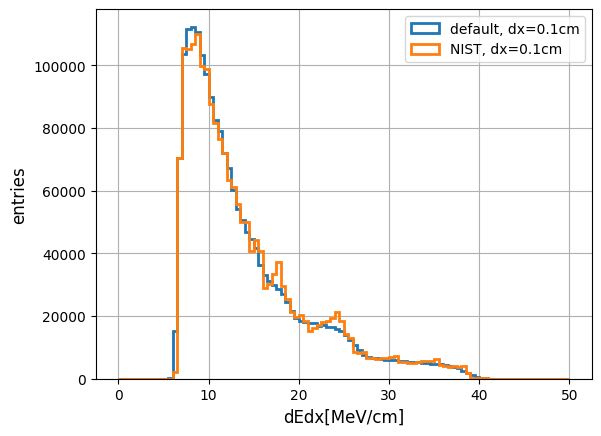

In [8]:
f1=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_dx_0.1cm.h5", "r")
f2=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx_dx_0.1cm.h5", "r")

seg1=f1['segments']
seg2=f2['segments']

plt.hist(seg1[(seg1['range']>0.15)&(seg1['dx']>1E-2)]['dEdx'], range=[0,50], bins=100, histtype='step', linewidth=2, label = "default, dx=0.1cm")
plt.hist(seg2[(seg2['range']>0.15)&(seg2['dx']>1E-2)]['dEdx'], range=[0,50], bins=100, histtype='step', linewidth=2, label = "NIST, dx=0.1cm")

plt.xlabel("dEdx[MeV/cm]", fontsize=12)
plt.ylabel("entries", fontsize=12)
plt.legend()
plt.grid()
plt.savefig("dEdx_comparison_seg_dx0.1cm.pdf")
plt.show()

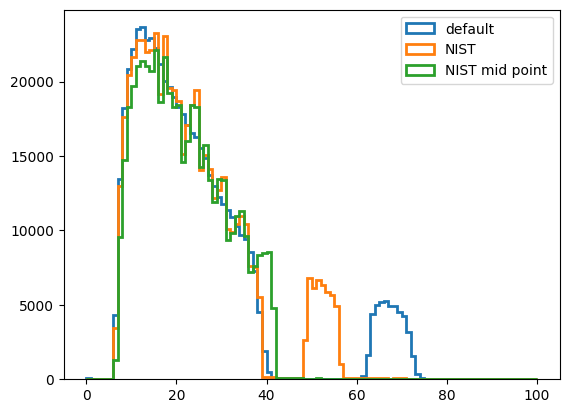

In [14]:
f1=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r")
f2=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx.h5", "r")
f3=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx_mid_seg.h5", "r")
plt.hist(f1['segments']['dEdx'], range=[0,100], bins=100, histtype='step', linewidth=2, label = "default")
plt.hist(f2['segments']['dEdx'], range=[0,100], bins=100, histtype='step', linewidth=2, label = "NIST")
plt.hist(f3['segments']['dEdx'], range=[0,100], bins=100, histtype='step', linewidth=2, label = "NIST mid point")
plt.legend()
plt.show()

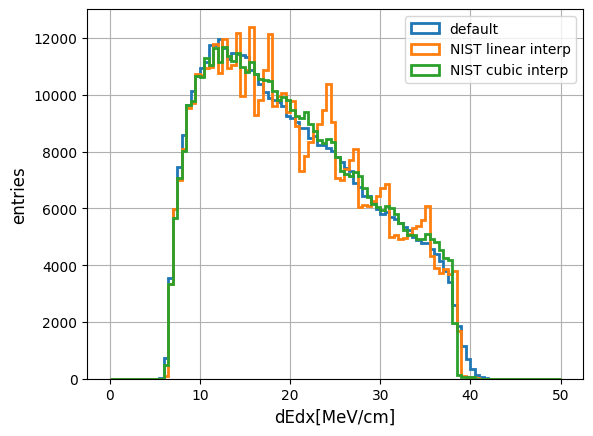

In [16]:
f1=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5", "r")
f2=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx.h5", "r")
f3=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx_cubic.h5", "r")
# f3=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx_dx_0.1cm.h5", "r")

seg1=f1['segments']
seg2=f2['segments']
seg3=f3['segments']

plt.hist(seg1[(seg1['range']>0.15)&(seg1['dx']>1E-2)]['dEdx'], range=[0,50], bins=100, histtype='step', linewidth=2, label = "default")
plt.hist(seg2[(seg2['range']>0.15)&(seg2['dx']>1E-2)]['dEdx'], range=[0,50], bins=100, histtype='step', linewidth=2, label = "NIST linear interp")
plt.hist(seg3[(seg3['range']>0.15)&(seg3['dx']>1E-2)]['dEdx'], range=[0,50], bins=100, histtype='step', linewidth=2, label = "NIST cubic interp")

plt.xlabel("dEdx[MeV/cm]", fontsize=12)
plt.ylabel("entries", fontsize=12)
plt.legend()
plt.grid()
plt.savefig("dEdx_comparison_edep_seg_three.pdf")
plt.show()

/lscratch/cyifan/tmp/ipykernel_1560496/2672550347.py:7: RuntimeWarning: divide by zero encountered in power
  dEdx_PIDA=A*(range**b)


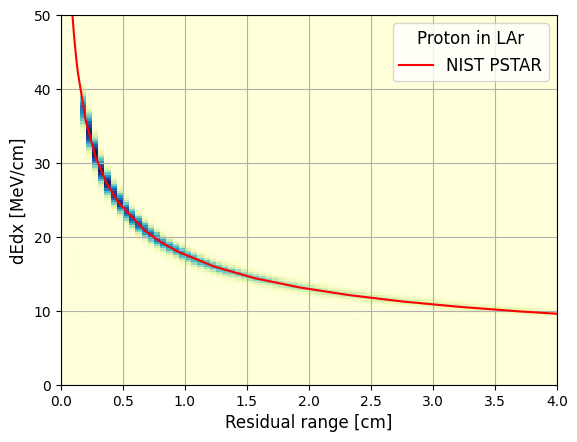

In [12]:
f=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5")
seg = f['segments']
plt.hist2d(seg[(seg['range']>0.1)&(seg['dx']>1E-2)]['range'], seg[(seg['range']>0.1)&(seg['dx']>1E-2)]['dEdx'],bins=[80,160],range=[[0,4],[0,50]], cmap="YlGnBu")
range=np.linspace(0,10,100)
A=17
b=-0.42
dEdx_PIDA=A*(range**b)
# plt.plot(range, dEdx_PIDA, color="red", label="ArgoNeuT PIDA")
plt.plot(Range_NIST[Range_NIST < 8], dEdx_NIST[Range_NIST < 8], color="red", label="NIST PSTAR")
plt.xlabel("Residual range [cm]",fontsize=12)
plt.ylabel("dEdx [MeV/cm]",fontsize=12)
lg= plt.legend(title="Proton in LAr",fontsize=12)
plt.setp(lg.get_title(),fontsize=12)
plt.grid()
plt.savefig("p_only_contained_dEdx_range_NIST_no_end.pdf")
# plt.colorbar()

plt.show()
# f.close()

/lscratch/cyifan/tmp/ipykernel_1560496/610466414.py:7: RuntimeWarning: divide by zero encountered in power
  dEdx_PIDA=A*(range**b)


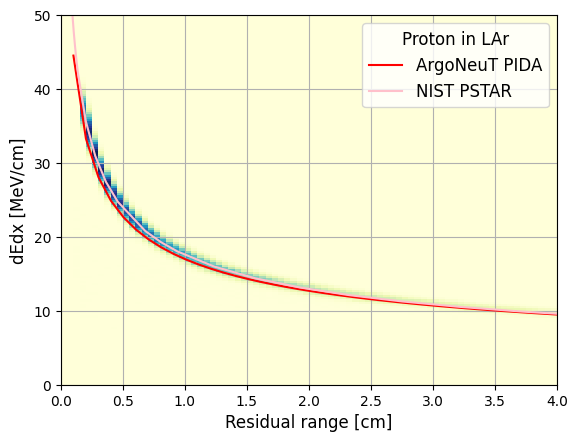

In [10]:
f=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5")
seg = f['segments']
plt.hist2d(seg[(seg['range']>0.1)&(seg['dx']>1E-2)]['range'], seg[(seg['range']>0.1)&(seg['dx']>1E-2)]['dEdx'],bins=[80,160],range=[[0,4],[0,50]], cmap="YlGnBu")
range=np.linspace(0,10,100)
A=17
b=-0.42
dEdx_PIDA=A*(range**b)
plt.plot(range, dEdx_PIDA, color="red", label="ArgoNeuT PIDA")
plt.plot(Range_NIST[Range_NIST < 8], dEdx_NIST[Range_NIST < 8], color="pink", label="NIST PSTAR")
plt.xlabel("Residual range [cm]",fontsize=12)
plt.ylabel("dEdx [MeV/cm]",fontsize=12)
lg= plt.legend(title="Proton in LAr",fontsize=12)
plt.setp(lg.get_title(),fontsize=12)
plt.grid()
plt.savefig("p_only_contained_dEdx_range_PIDA_NIST_no_end.pdf")
# plt.colorbar()

plt.show()
# f.close()

/lscratch/cyifan/tmp/ipykernel_1993972/1528238469.py:6: RuntimeWarning: divide by zero encountered in power
  dEdx_PIDA=A*(range**b)


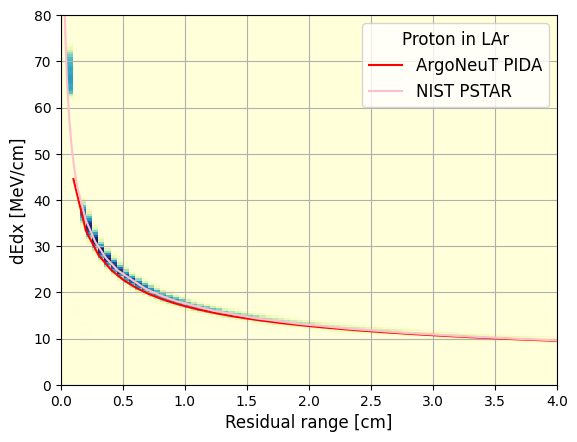

In [36]:
f=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5")
plt.hist2d(f['segments']['range'], f['segments']['dEdx'],bins=[80,160],range=[[0,4],[0,80]], cmap="YlGnBu")
range=np.linspace(0,10,100)
A=17
b=-0.42
dEdx_PIDA=A*(range**b)
plt.plot(range, dEdx_PIDA, color="red", label="ArgoNeuT PIDA")
plt.plot(Range_NIST[Range_NIST < 8], dEdx_NIST[Range_NIST < 8], color="pink", label="NIST PSTAR")
plt.xlabel("Residual range [cm]",fontsize=12)
plt.ylabel("dEdx [MeV/cm]",fontsize=12)
lg= plt.legend(title="Proton in LAr",fontsize=12)
plt.setp(lg.get_title(),fontsize=12)
plt.grid()
plt.savefig("p_only_contained_dEdx_range_PIDA_NIST.pdf")
# plt.colorbar()

plt.show()
# f.close()

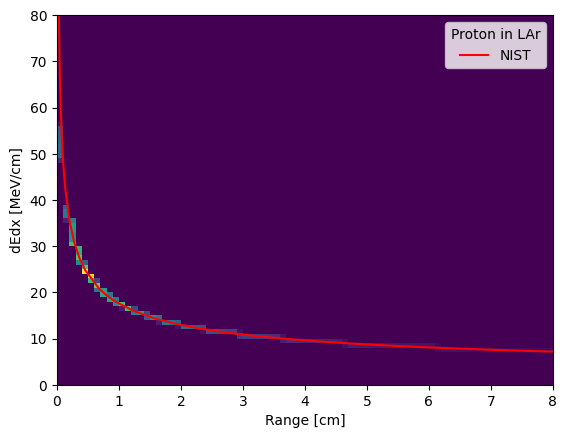

In [21]:
f=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_NIST_dEdx.h5")
plt.hist2d(f['segments']['range'], f['segments']['dEdx'],bins=[80,80],range=[[0,8],[0,80]])
# range=np.linspace(0,10,100)
# A=17
# b=-0.42
# dEdx_PIDA=A*(range**b)
# plt.plot(range, dEdx_PIDA, color="yellow", label="PIDA")
plt.plot(Range_NIST, dEdx_NIST, color="red", label="NIST")
plt.xlabel("Range [cm]")
plt.ylabel("dEdx [MeV/cm]")
plt.legend(title="Proton in LAr")
# plt.savefig("p_only_contained_dEdx_range_not_selected_5000ev.pdf")
# plt.colorbar()
plt.show()
# f.close()

/lscratch/cyifan/tmp/ipykernel_2060172/3896179926.py:6: RuntimeWarning: divide by zero encountered in power
  dEdx=A*(range**b)


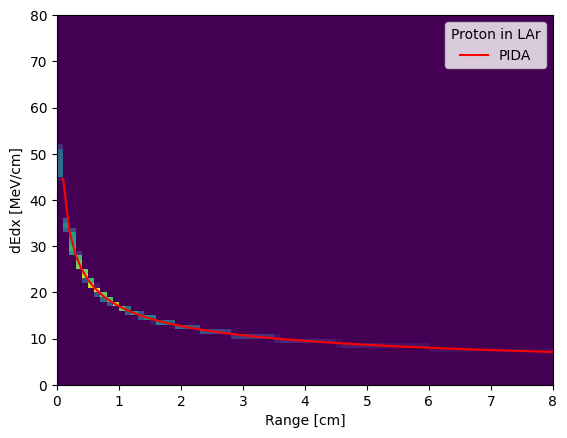

In [20]:
f=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000_PIDA_dEdx.h5")
plt.hist2d(f['segments']['range'], f['segments']['dEdx'],bins=[80,80],range=[[0,8],[0,80]])
range=np.linspace(0,10,100)
A=17
b=-0.42
dEdx=A*(range**b)
plt.plot(range, dEdx, color="red", label="PIDA")
plt.xlabel("Range [cm]")
plt.ylabel("dEdx [MeV/cm]")
plt.legend(title="Proton in LAr")
# plt.savefig("p_only_contained_dEdx_range_not_selected_5000ev.pdf")
# plt.colorbar()
plt.show()
# f.close()

## Muon--Proton sample comparison

In [2]:
f_p=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/fake_data_S1/edepsim_p_only_active_vol_5000.h5")
f_mu=h5py.File("/sdf/group/neutrino/cyifan/muon-sim/larndsim_output/f_1000_mu_3GeV/f1000_mu_3GeV_edep_selected.h5")
seg_p=f_p['segments']
seg_mu=f_mu['segments']

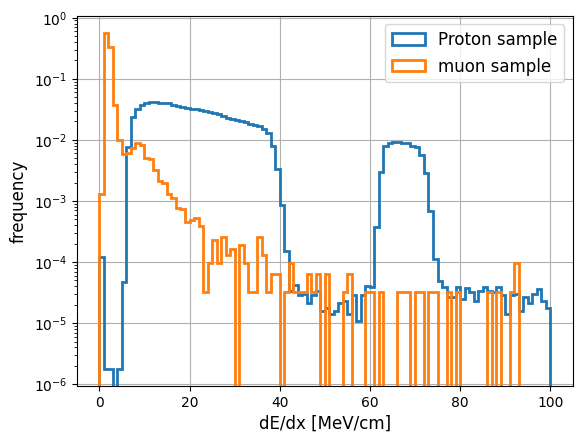

In [21]:
plt.hist(seg_p['dEdx'],density=True,range=[0,100], bins=100, histtype='step',label="Proton sample", linewidth=2)
plt.hist(seg_mu['dEdx'],density=True,range=[0,100], bins=100, histtype='step', label="muon sample", linewidth=2)
plt.legend(fontsize=12)
plt.xlabel("dE/dx [MeV/cm]", fontsize=12)
plt.ylabel("frequency", fontsize=12)
plt.grid()
plt.yscale("log")
plt.savefig("proton_muon_dEdx.pdf")
plt.show()

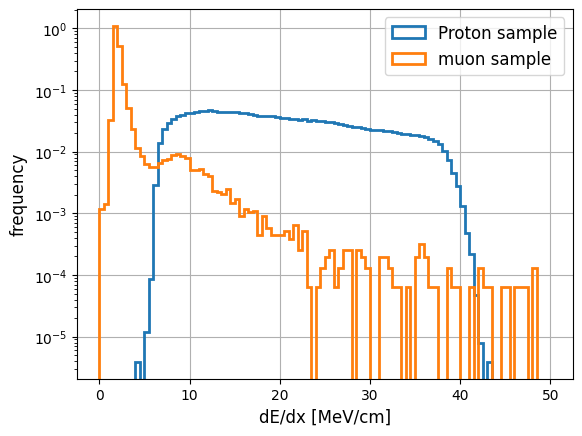

In [30]:
plt.hist(seg_p[(seg_p['dx']>1E-2)&(seg_p['range']>0.15)]['dEdx'],density=True,range=[0,50], bins=100, histtype='step',label="Proton sample", linewidth=2)
plt.hist(seg_mu['dEdx'],density=True,range=[0,50], bins=100, histtype='step', label="muon sample", linewidth=2)
plt.legend(fontsize=12)
plt.xlabel("dE/dx [MeV/cm]", fontsize=12)
plt.ylabel("frequency", fontsize=12)
plt.grid()
plt.yscale("log")
plt.savefig("proton_muon_dEdx_0_50.pdf")
plt.show()

## Event display

In [48]:
def plot_tracks(tracks, **kwargs):
    '''
    Plot tracks. Segments are jointed by straight line.
    
    Arguments
    ---------
    tracks : array_like
        A list of track segements.
        
    **kwargs:
        additional keyword arguments passed to `Scatter3d``
        
    Returns
    -------
    trace: Scatter3d
        plolty trace object
    '''
    
    def to_list(axis):
        return np.column_stack([
            tracks[f'{axis}_start'],
            tracks[f'{axis}_end'],
            np.full(len(tracks), None)
        ]).flatten().tolist()
        
    x, y, z = (to_list(axis) for axis in 'xyz')
    trace = go.Scatter3d(x=x, y=y, z=z, **kwargs)
    
    return trace

def draw_anode_planes(geom, **kwargs):
    '''
    Draw two anode planes for module0.
    
    TODO(2021-11-09 kvt) for other detector geometry?
    
    Arguments
    ---------
    geom : dict
        tile geometry from `load_tile_geometry()`
    
    **kwargs :
        additional keyword arguments passed to `Surface`
        
    Returns
    -------
    traces: list(Scatter3d)
        plolty Surface objects
    '''

    pos = np.array(list(geom.values())) / 10.
    mask = pos[:,2] > 0
    traces = []
    
    for m in (mask, ~mask):
        x = np.array([pos[m,0].min(), pos[m,0].max()])
        y = np.array([pos[m,1].min(), pos[m,1].max()])
        z = np.full((2,2), pos[m,2].max())

        traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    
    return traces

def draw_cathode_planes(geom, **kwargs):
    '''
    Draw two anode planes for module0.
    
    TODO(2021-11-09 kvt) for other detector geometry?
    
    Arguments
    ---------
    geom : dict
        tile geometry from `load_tile_geometry()`
    
    **kwargs :
        additional keyword arguments passed to `Surface`
        
    Returns
    -------
    traces: list(Scatter3d)
        plolty Surface objects
    '''

    pos = np.array(list(geom.values())) / 10.
    mask = pos[:,2] > 0
    traces = []
    
    for m in (mask, ~mask):
        x = np.array([pos[m,0].min(), pos[m,0].max()])
        y = np.array([pos[m,1].min(), pos[m,1].max()])
        z = np.full((2,2), 0)

        traces.append(go.Surface(x=x, y=y, z=z, **kwargs))
    
    return traces

def _rotate_pixel(pixel_pos, tile_orientation):
    return pixel_pos[0]*tile_orientation[2], pixel_pos[1]*tile_orientation[1]

def load_tile_geometry(fpath):
    '''
    Build a dictionary for position lookup from tile layout.
    
    Mostly copid from `larnd-sim/examples` [2d402e5]
    
    Arguments
    ---------
    fpath : str
        file path to the tile layout
    
    Returns
    -------
    geometry : dict
        dictionary of tile position in mm
        `geometry[(io_group, io_channel, chip, channel)] -> (x,y,z)`   
    '''
    with open(fpath, 'r') as f:
        geometry_yaml = yaml.load(f, Loader=yaml.FullLoader)
        
    pixel_pitch = geometry_yaml['pixel_pitch']
    is_multi_tile = True
    chip_channel_to_position = geometry_yaml['chip_channel_to_position']
    tile_orientations = geometry_yaml['tile_orientations']
    tile_positions = geometry_yaml['tile_positions']
    tpc_centers = geometry_yaml['tpc_centers']
    tile_indeces = geometry_yaml['tile_indeces']
    xs = np.array(list(chip_channel_to_position.values()))[:, 0] * pixel_pitch
    ys = np.array(list(chip_channel_to_position.values()))[:, 1] * pixel_pitch
    x_size = max(xs)-min(xs)+pixel_pitch
    y_size = max(ys)-min(ys)+pixel_pitch
    tile_geometry = defaultdict(int)
    geometry = defaultdict(lambda: (0,0))
    io_group_io_channel_to_tile = {}
    
    for tile in geometry_yaml['tile_chip_to_io']:
        tile_orientation = tile_orientations[tile]
        tile_geometry[tile] = tile_positions[tile], tile_orientations[tile]

        for chip in geometry_yaml['tile_chip_to_io'][tile]:
            io_group_io_channel = geometry_yaml['tile_chip_to_io'][tile][chip]
            io_group = io_group_io_channel//1000
            io_channel = io_group_io_channel % 1000
            io_group_io_channel_to_tile[(
                io_group, io_channel)] = tile
        for chip_channel in geometry_yaml['chip_channel_to_position']:
            chip = chip_channel // 1000
            channel = chip_channel % 1000
            try:
                io_group_io_channel = geometry_yaml['tile_chip_to_io'][tile][chip]
            except KeyError:
                #print("Chip %i on tile %i not present in network" % (chip,tile))
                continue

            io_group = io_group_io_channel // 1000
            io_channel = io_group_io_channel % 1000
            x = chip_channel_to_position[chip_channel][0] * \
                pixel_pitch - x_size / 2 + pixel_pitch / 2
            y = chip_channel_to_position[chip_channel][1] * \
                pixel_pitch - y_size / 2 + pixel_pitch / 2 

            x, y = _rotate_pixel((x, y), tile_orientation)
            x += tile_positions[tile][2] + \
                tpc_centers[tile_indeces[tile][1]][0]
            y += tile_positions[tile][1] + \
                tpc_centers[tile_indeces[tile][1]][1]

            z = tile_positions[tile][0] + \
                tpc_centers[tile_indeces[tile][1]][2]

            # FIXME(2021-11-09 kvt) y-offset between edep-sim and larnd-sim
            y -= 21.8236 * 10
            
            geometry[(io_group, io_channel, chip, channel)] = x, y, z
            
    return dict(geometry)


In [49]:
import os
from collections import defaultdict
larnd_sim_dir='/sdf/group/neutrino/cyifan/dunend_train_prod_mpvmpr_git/modules/larnd-sim/'
layout_file = os.path.join(larnd_sim_dir, 'larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml')
geom = load_tile_geometry(layout_file)



In [43]:
tracks = f_p['segments']
event_ids = np.unique(tracks['eventID'])

In [56]:
import plotly.graph_objects as go
# -----------------------------------------------------------------------------
# pick an event
# -----------------------------------------------------------------------------
i_evt = 1
evt_id = event_ids[i_evt]

evt_mask = tracks['eventID'] == evt_id
# pckt_mask = pckt_event_ids == evt_id

fig = go.Figure()
# -----------------------------------------------------------------------------
# Draw anode planes
# -----------------------------------------------------------------------------
fig.add_traces(draw_anode_planes(
    geom,
    showscale=False,
    opacity=0.3,
    colorscale='ice',
))

fig.add_traces(draw_cathode_planes(
    geom,
    showscale=False,
    opacity=0.3,
    colorscale='Greys',
))


# -----------------------------------------------------------------------------
# Plot tracks
# -----------------------------------------------------------------------------
selected_tracks = tracks[evt_mask]
track_ids = selected_tracks['trackID']
track_uids = np.unique(track_ids)

traces = []
for track_id in track_uids:
    mask = track_ids == track_id
    
    traces.append(plot_tracks(
        selected_tracks[mask],
        showlegend=False,
        legendgroup='tracks',
        mode='lines',
        line_width=5.,
        line_color=selected_tracks["dE"],
        marker_size=3.
    )
)
traces[0].update(showlegend=True, name='Tracks')
fig.add_traces(traces)

# -----------------------------------------------------------------------------
# Eye candies (style & layout)
# -----------------------------------------------------------------------------
fig.update_layout(
#     template='plotly_dark',
    width=1024, height=768,
    legend_orientation="h",
)
